In [2]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


c:\Users\viviv\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# convert str to datatime 
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [8]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


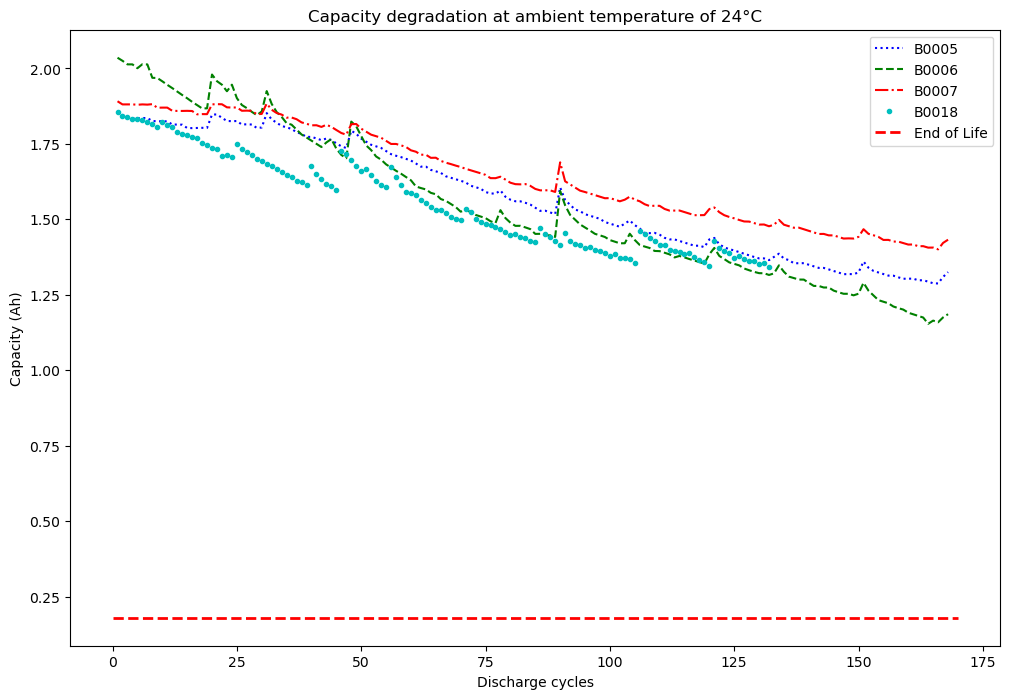

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
#EOL: Battery reaches 80% of capacity
EOL = ax.hlines(y=0.18,xmin = 0, xmax = 170, linewidth=2, color='r', linestyles = 'dashed', label='End of Life')
plt.legend()

In [ ]:
def triplet_generate(data, info, size, target_var):
    triplets_x = np.zeros((len(data), 4, size))
    triplets_y = np.zeros((len(data), 4, 10 * len(target_var)))
    
    for i in range(len(data)):
        pos = 0
        x_len = info.iloc[i]['x_len']
        y_len = info.iloc[i]['y_len']
        triplets_y[i, 3, :y_len] = 1
        for j in range(y_len):
            for k in range(3):
                triplets_y[i, k, pos] = data[i][k][x_len + j]
            pos += 1
        
        # feature selection
        pos = 0
        if x_len > size:
            out = False
            vs = None
            triplets_x[i, 3] = 1
            ct = pd.DataFrame(np.zeros(len(target_var)).reshape((1, -1)), columns = list(target_var))
            while pos < size:
                if out:
                    out = False
                    ct = ct.drop(columns = vs)
                if len(ct.columns) > 0:
                    vs = ct.columns[-1]
                    for j in range(len(ct.columns) - 1):
                        if ct[ct.columns[j]].item() <= ct[ct.columns[j + 1]].item():
                            vs = ct.columns[j]
                            break
                        
                    out = True
                    for j in range(x_len):
                        if data[i][0][j] == vs:
                            for k in range(3):
                                triplets_x[i, k, pos] = data[i][k][j]
                                data[i][k] = np.delete(data[i][k], j)
                            x_len -= 1
                            pos += 1
                            ct[vs] += 1
                            out = False
                            break
                        
                else:
                    s = int(np.random.rand() * x_len)
                    for k in range(3):
                        triplets_x[i, k, pos] = data[i][k][s]
                        data[i][k] = np.delete(data[i][k], s)
                        
                    x_len -= 1
                    pos += 1
            s = np.argsort(triplets_x[i][1])
            for j in range(3):
                triplets_x[i][j] = triplets_x[i][j][s]
                
        else:
            triplets_x[i, 3, :x_len] = 1
            for j in range(x_len):
                for k in range(3):
                    triplets_x[i, k, pos] = data[i][k][j]
                pos += 1
    
    return triplets_x, triplets_y, info